In [49]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder
from sklearn.tree import DecisionTreeClassifier


### Read Test+train Datasets

In [50]:
X_train_path = 'X_train.csv'
y_train_path = 'y_train.csv'
X_test_path = 'X_test.csv'

# Read the csv files
X_train = pd.read_csv(X_train_path, index_col=0)
y_train = pd.read_csv(y_train_path, index_col=0)
X_test = pd.read_csv(X_test_path, index_col=0)

# Remove redundant id column
X_train.drop(columns=['id'], inplace=True)
X_test.drop(columns=['id'], inplace=True)

joined_df = X_train.join(y_train)
joined_df.head()


,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race,LeaveOrNot
1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,white,0
2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,white,0
4610,Bachelors,2015,Pune,3,26.0,Female,No,2,white,1
2228,Bachelors,2012,Bangalore,3,29.0,Male,No,1,black,0
5,Bachelors,2016,Bangalore,3,24.0,Male,No,0,white,0


In [51]:
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]


In [52]:
rnd_state = 10

# Define the pipeline
num_attrs = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']
cat_attrs = ['Education', 'City', 'Gender', 'EverBenched', 'Race']
education_order = ["Bachelors", "Masters", "PHD"]

# Adding a scaler to the pipeline
ct = ColumnTransformer([
        ('TargetEncoder', TargetEncoder(), ['City', 'Race']),
        ('EducationLevelEncoder', OrdinalEncoder(categories=[education_order]), ['Education']),
        ('imputer', SimpleImputer(strategy="median"), num_attrs),
        ('dummy', FunctionTransformer(pd.get_dummies, kw_args={'drop_first': True, "dtype": int}), ['EverBenched', 'Gender'])
    ], remainder='passthrough', verbose_feature_names_out=False)
ct.set_output(transform='pandas')

scaler_transformer = make_column_transformer((StandardScaler(), num_attrs), remainder='passthrough', verbose_feature_names_out=False)
scaler_transformer.set_output(transform='pandas')

full_pipeline = Pipeline([
    ('ColumnTransformers', ct),
    ('scaler', scaler_transformer),
])

# Drop duplicates
joined_df = joined_df.drop_duplicates()
y_train, X_train = joined_df['LeaveOrNot'], joined_df[X_train.columns]

# Fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train, y_train)


c:\Python\Python10\lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


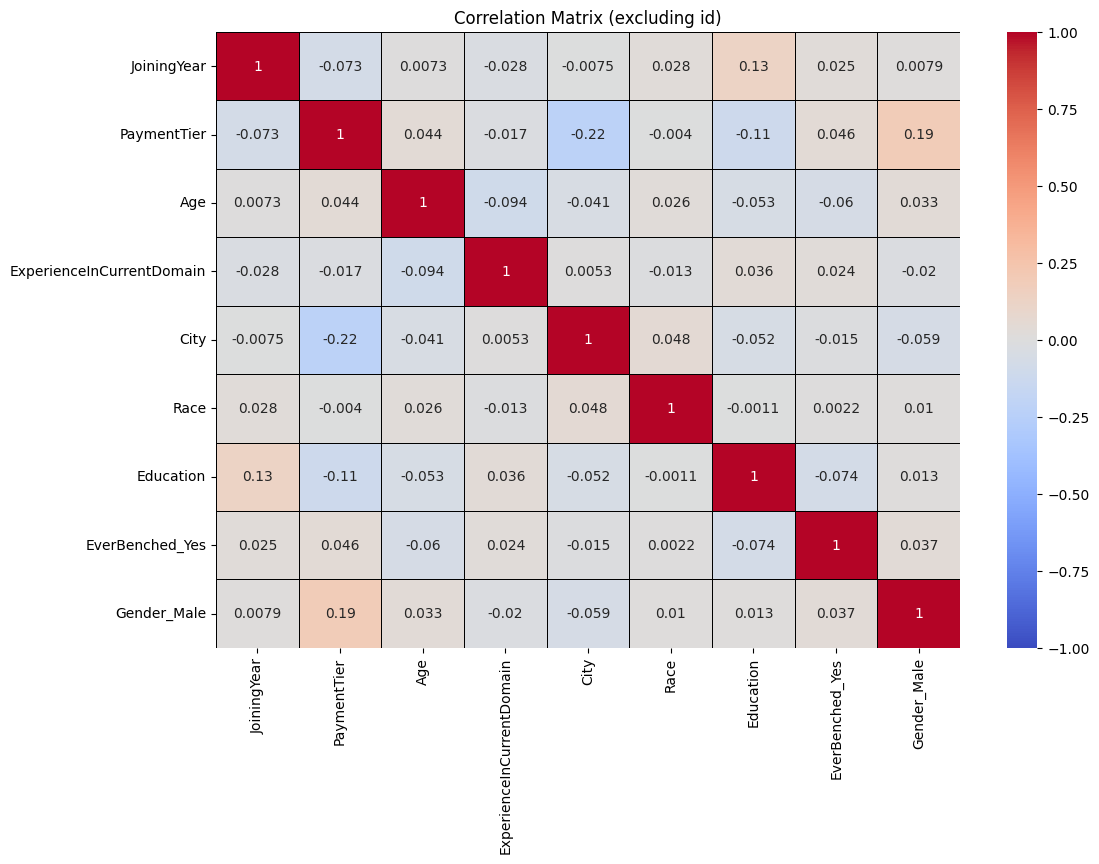

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
# Plotting the heatmap without 'id'
plt.figure(figsize=(12, 8))
sns.heatmap(X_train_prepared.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix (excluding id)')
plt.show()


In [54]:
# validate nan values
if X_train_prepared.isna().sum().sum() > 0:
    print('!There are nan values in the dataframe!')

full_train_ds = X_train_prepared.join(y_train)
full_train_ds.head()


,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,City,Race,Education,EverBenched_Yes,Gender_Male,LeaveOrNot
1847,0.487931,0.56819,-0.902113,0.781183,0.328247,0.382188,0.0,1,1,0
2905,-1.639697,0.56819,-0.704066,0.781183,0.328247,0.382188,0.0,0,1,0
4610,-0.043976,0.56819,-1.100159,-0.478302,0.507284,0.382188,0.0,0,0,1
2228,-1.639697,0.56819,-0.506020,-1.108045,0.328247,0.376183,0.0,0,1,0
5,0.487931,0.56819,-1.496252,-1.737787,0.328247,0.382188,0.0,0,1,0


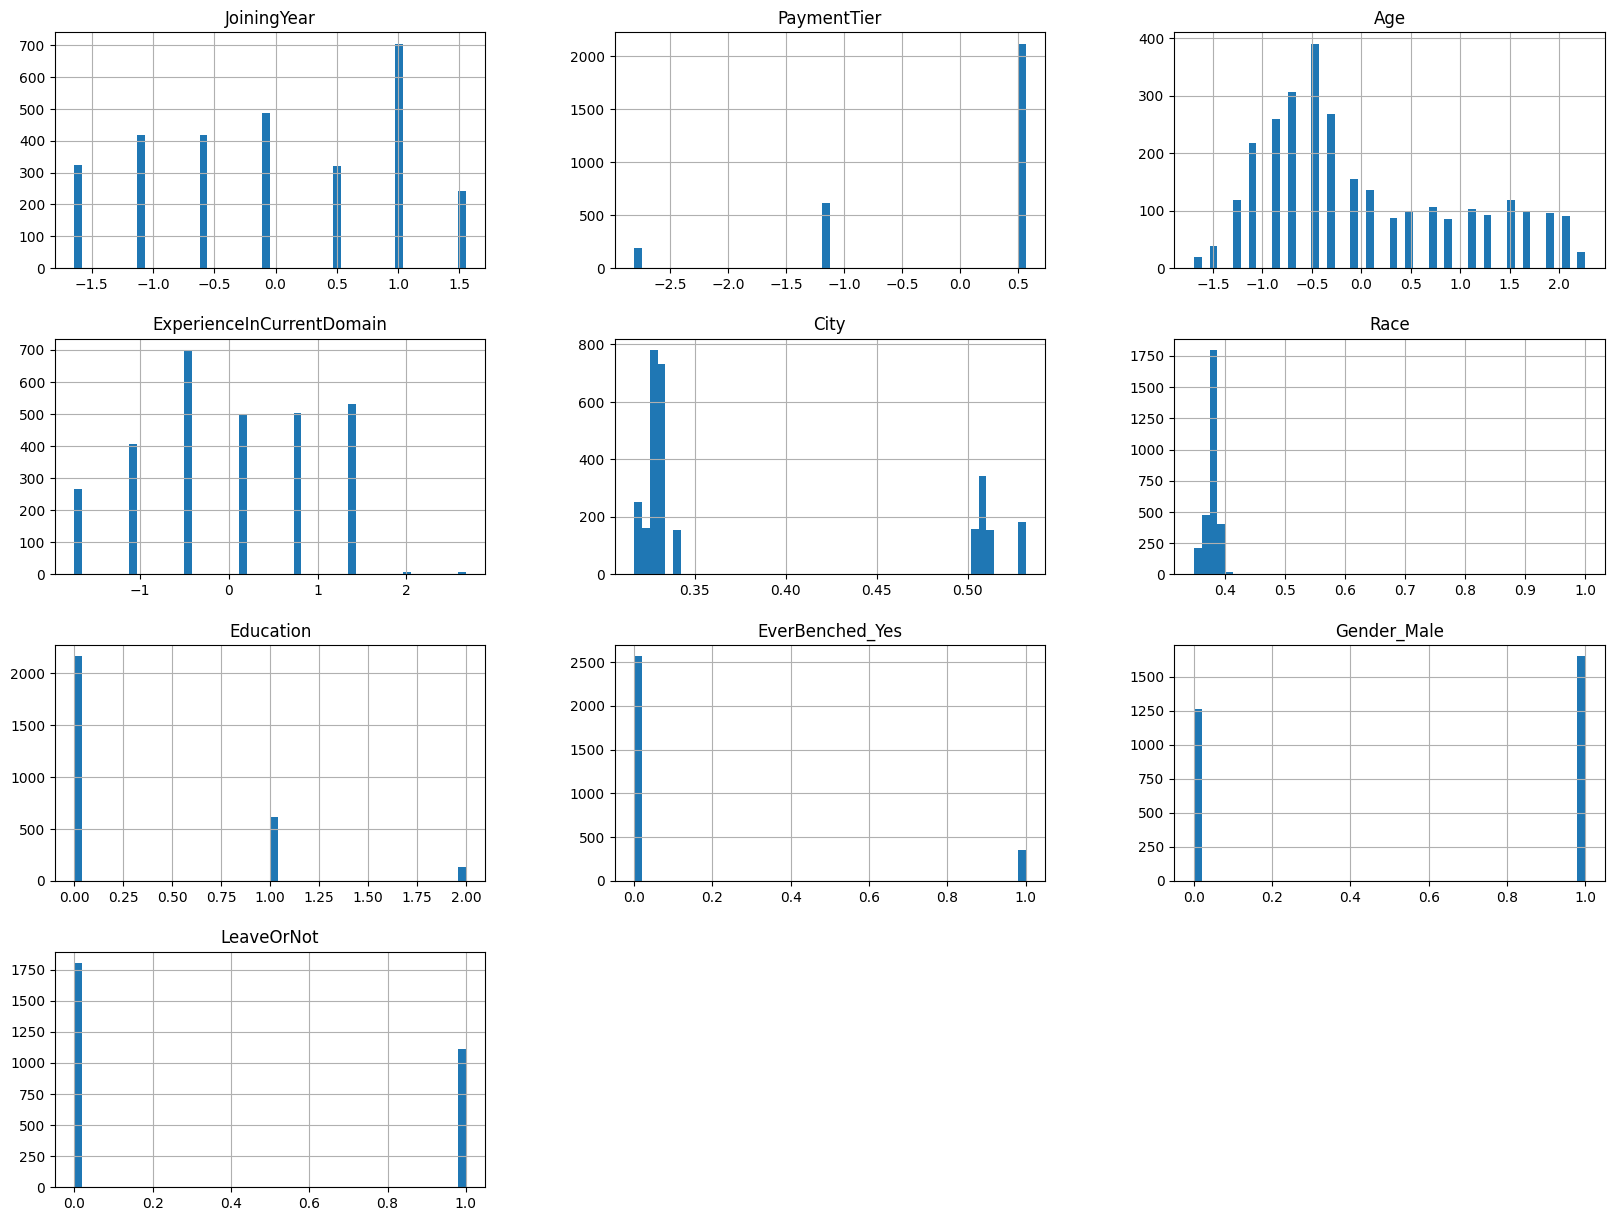

In [55]:
import matplotlib.pyplot as plt

# Plot histograms of all the columns
full_train_ds.hist(bins=50, figsize=(20,15))
plt.show()


In [56]:
# Defining the classifiers and their hyperparameters
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=rnd_state),
        'params': {
            'C': [0.3, 0.5, 1],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear' , 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=rnd_state),
        'params': {
            'max_depth': [7, 8, 9],
            'min_samples_split': [14, 15, 16]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3]
        }
    },
    'Gaussian Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=rnd_state),
        'params': {
            'n_estimators': [100, 110],
            'max_depth': [15],
            'min_samples_split': [11, 12],
            'min_samples_leaf': [3, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [False]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=rnd_state),
        'params': {
            'n_estimators': [120, 130],
            'learning_rate': [0.03],
            'max_depth': [5],
            'subsample': [0.9],
            'min_samples_split': [3, 4, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=rnd_state),
        'params': {
            'n_estimators': [50],
            'learning_rate': [1.2, 1.3],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=rnd_state),
        'params': {
            'n_estimators': [110, 120],
            'learning_rate': [0.01, 0.04, 0.05],
            'max_depth': [4, 5, 7, 10],
            'gamma': [0.1],
            'subsample': [0.9, 1.0],
            'colsample_bytree': [0.8, 0.9]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(force_row_wise=True, random_state=rnd_state),
        'params': {
            'n_estimators': [70, 80, 90, 100],
            'learning_rate': [0.1, 0.3, 0.4, 0.5],
            'max_depth': [2, 3, 4, 5, 10, 15]
        }
    }
}


In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE


# Function to compute metrics for the best model from GridSearchCV
def compute_metrics(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return f1, auc, precision, recall, accuracy


def calculate_metrics(classifiers, X_train, y_train, kfold_cnt: int):
    # To store the best model and its metrics for each classifier
    results = {}

    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,
                                                        random_state=rnd_state, stratify=y_train)
    # Oversample the minority class
    oversample = SMOTE(random_state=rnd_state)
    #oversample = ADASYN(random_state=rnd_state)
    X_train, y_train = oversample.fit_resample(X_train, y_train)


    kfold = StratifiedKFold(n_splits=kfold_cnt, shuffle=True, random_state=rnd_state)

    trained_models = []

    # Iterating over each classifier and performing Grid Search
    for classifier_name, classifier_info in classifiers.items():
        # GridSearchCV
        grid_search = GridSearchCV(classifier_info['model'], classifier_info['params'],
                                   cv=kfold, scoring='f1', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        # Compute metrics for the best model
        f1, auc, precision, recall, accuracy = compute_metrics(grid_search.best_estimator_, X_test, y_test)

        # Store results
        results[classifier_name] = {
            'F1 Score': f1,
            'AUC': auc,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Best Parameters': grid_search.best_params_,
            'confusion matrix': confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)),
        }
        trained_models.append(grid_search.best_estimator_)

    results_df = pd.DataFrame(results).T
    return trained_models, results_df


In [62]:
trained_models, scores = calculate_metrics(classifiers, X_train_prepared, y_train, 5)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 1263, number of negative: 1263
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 2526, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [63]:
# pandas df plot score with best highlighted
to_plot = scores[['F1 Score', 'AUC', 'Precision', 'Recall', 'Accuracy']]
to_plot.style.highlight_max(color = 'darkgreen', axis = 0)


,F1 Score,AUC,Precision,Recall,Accuracy
Logistic Regression,0.554348,0.680684,0.506203,0.612613,0.625143
Decision Tree,0.697987,0.823158,0.790875,0.624625,0.794286
KNN,0.589474,0.705731,0.590361,0.588589,0.688000
Gaussian Naive Bayes,0.542894,0.673820,0.473214,0.636637,0.592000
Random Forest,0.713551,0.828602,0.832000,0.624625,0.809143
Gradient Boosting,0.699659,0.835250,0.810277,0.615616,0.798857
AdaBoost,0.658979,0.787931,0.729927,0.600601,0.763429
XGBoost,0.716216,0.835472,0.818533,0.636637,0.808000
LightGBM,0.695652,0.818748,0.784906,0.624625,0.792000


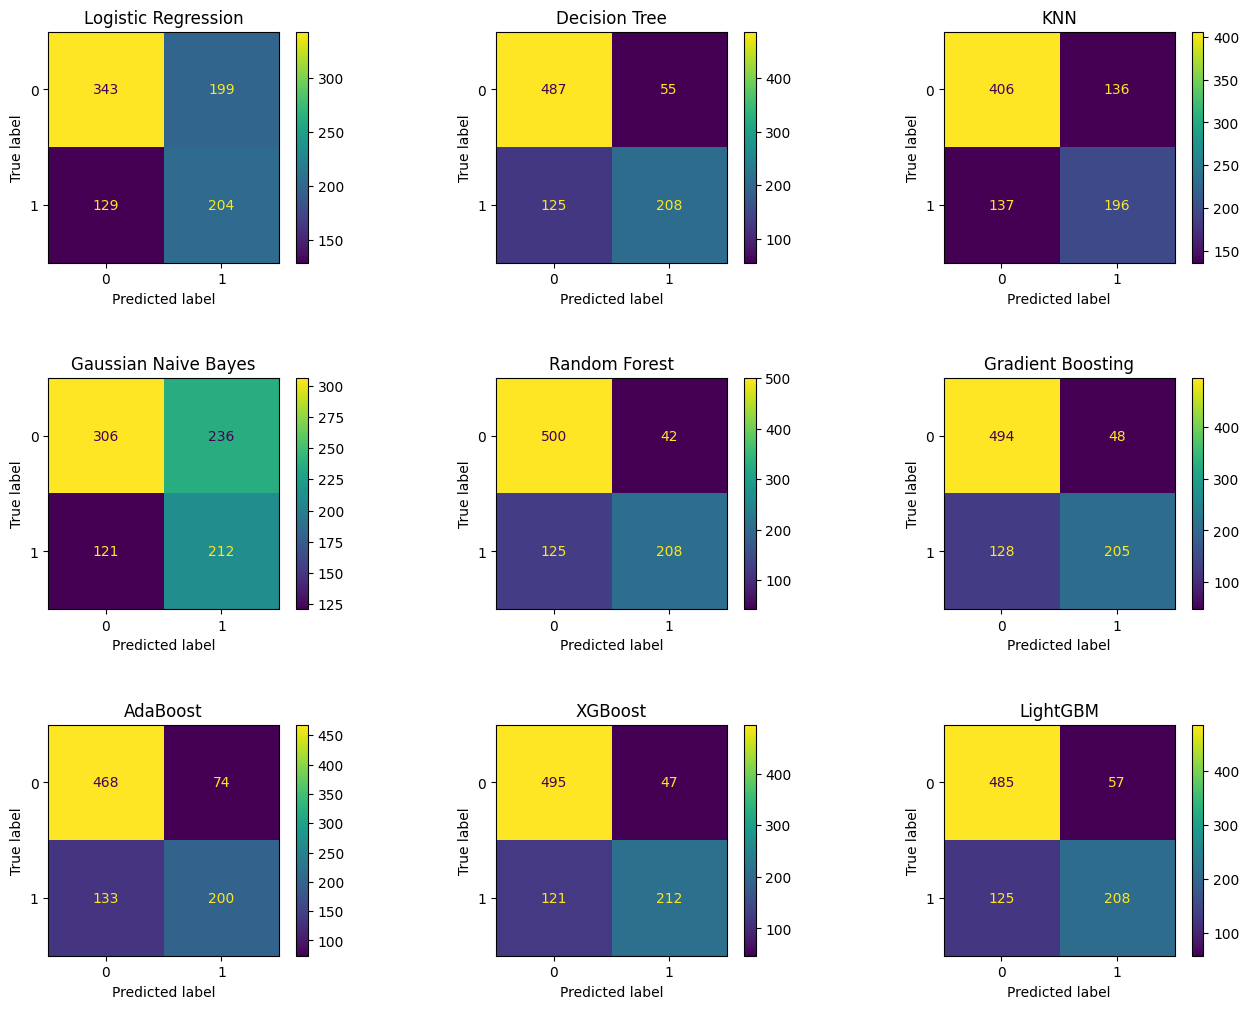

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay
from math import ceil

# create a grid of subplots according to the length of the results
# 2 plots for each row.
fig, axs = plt.subplots(ceil(len(scores) / 3), 3, figsize=(16, 12), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

# Confusion matrix for each classifier
for i, result in enumerate(scores.iterrows()):
    model_name = result[0]
    # plot confusion matrix
    cm = result[1]['confusion matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[i // 3, i % 3])

    # add the model name as a title
    axs[i // 3, i % 3].set_title(model_name)

    # Increase the vertical margins
    axs[i // 3, i % 3].set_ymargin(200)


In [65]:
from pprint import pprint
pprint(scores['Best Parameters'].to_dict())


{'AdaBoost': {'algorithm': 'SAMME.R', 'learning_rate': 1.2, 'n_estimators': 50},
 'Decision Tree': {'max_depth': 8, 'min_samples_split': 16},
 'Gaussian Naive Bayes': {},
 'Gradient Boosting': {'learning_rate': 0.03,
                       'max_depth': 5,
                       'min_samples_split': 5,
                       'n_estimators': 130,
                       'subsample': 0.9},
 'KNN': {'n_neighbors': 3},
 'LightGBM': {'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 90},
 'Logistic Regression': {'C': 0.3, 'penalty': 'l2', 'solver': 'saga'},
 'Random Forest': {'bootstrap': False,
                   'max_depth': 15,
                   'max_features': 'sqrt',
                   'min_samples_leaf': 4,
                   'min_samples_split': 11,
                   'n_estimators': 110},
 'XGBoost': {'colsample_bytree': 0.9,
             'gamma': 0.1,
             'learning_rate': 0.05,
             'max_depth': 7,
             'n_estimators': 120,
             'subsample': 0.9}

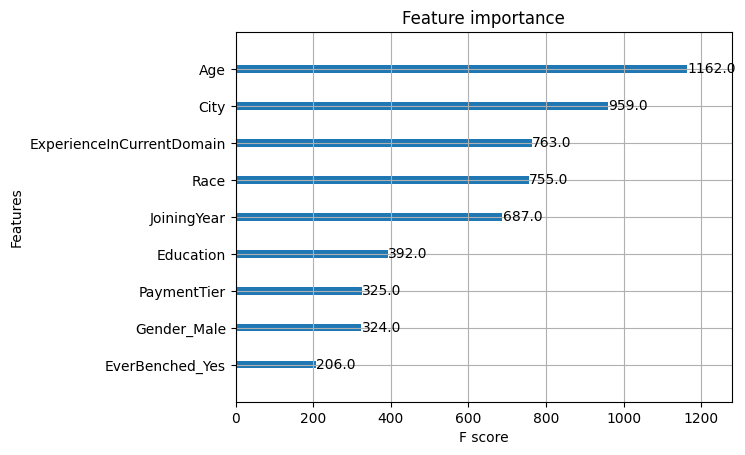

<Figure size 1600x1200 with 0 Axes>

In [66]:
# Importance of features for xgboost
xgb_clf = xgb.XGBClassifier(**scores.loc['XGBoost']['Best Parameters'])
xgb_clf.fit(X_train_prepared, y_train)
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()


In [68]:
# Take the top 5 performant models and ensemble them into a single model
from sklearn.ensemble import VotingClassifier
most_performant = scores.sort_values(by='F1 Score', ascending=False).head(5)

# Create the models with the parameters
models = []
for result in most_performant.iterrows():
    model =  classifiers[result[0]]['model'].set_params(**result[1]['Best Parameters'])
    # Best Parameters
    models.append(model)

ansemble = VotingClassifier(estimators=[(model.__class__.__name__, model) for model in models], voting='soft')
ansemble


VotingClassifier(estimators=[('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=Non...
                              GradientBoostingClassifier(learning_rate=0.03,
                                                         max_depth=5,
                                                         min_samples_split=5,
                                                         n_estimators=130,
                                                         random_state=10,
                                                         subsample=0.9)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(max_depth=8,
                                                     min_samples_split=16,
                                                     random_state=10)),
                             ('LGBMClassifier',
                              LGBMClassifier(force_row_wise=True,
                                             learning_rate=0.4, max_depth=3,
                                             n_estimators=90,
                                             random_state=10))],
                 voting='soft')

In [69]:
def train_model(model, X_train, y_train):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,
                                                        random_state=rnd_state, stratify=y_train)

    # Oversample the minority class
    oversample = SMOTE(random_state=rnd_state)
    #oversample = ADASYN(random_state=rnd_state)
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # train
    model = model.fit(X_train, y_train)

    # get scores
    f1, auc, precision, recall, accuracy = compute_metrics(model, X_test, y_test)
    result = {
        'F1 Score': f1,
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'confusion matrix': confusion_matrix(y_test, model.predict(X_test)),
    }
    return model, result


trained_model, ansemble_scores = train_model(ansemble, X_train_prepared, y_train)


[LightGBM] [Info] Number of positive: 1263, number of negative: 1263
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 2526, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [70]:
all_scores = pd.concat([to_plot.loc[:], pd.DataFrame([ansemble_scores], index=['Ensemble'])]).drop('confusion matrix', axis=1)
all_scores.style.highlight_max(color = 'darkgreen', axis = 0)


,F1 Score,AUC,Precision,Recall,Accuracy
Logistic Regression,0.554348,0.680684,0.506203,0.612613,0.625143
Decision Tree,0.697987,0.823158,0.790875,0.624625,0.794286
KNN,0.589474,0.705731,0.590361,0.588589,0.688000
Gaussian Naive Bayes,0.542894,0.673820,0.473214,0.636637,0.592000
Random Forest,0.713551,0.828602,0.832000,0.624625,0.809143
Gradient Boosting,0.699659,0.835250,0.810277,0.615616,0.798857
AdaBoost,0.658979,0.787931,0.729927,0.600601,0.763429
XGBoost,0.716216,0.835472,0.818533,0.636637,0.808000
LightGBM,0.695652,0.818748,0.784906,0.624625,0.792000
Ensemble,0.715254,0.836641,0.821012,0.633634,0.808000


#### Retraining the model with the best F1 Score which is till XGBoost on the full dataset available


In [76]:
scores


,F1 Score,AUC,Precision,Recall,Accuracy,Best Parameters,confusion matrix
Logistic Regression,0.554348,0.680684,0.506203,0.612613,0.625143,"{'C': 0.3, 'penalty': 'l2', 'solver': 'saga'}","[[343, 199], [129, 204]]"
Decision Tree,0.697987,0.823158,0.790875,0.624625,0.794286,"{'max_depth': 8, 'min_samples_split': 16}","[[487, 55], [125, 208]]"
KNN,0.589474,0.705731,0.590361,0.588589,0.688,{'n_neighbors': 3},"[[406, 136], [137, 196]]"
Gaussian Naive Bayes,0.542894,0.67382,0.473214,0.636637,0.592,{},"[[306, 236], [121, 212]]"
Random Forest,0.713551,0.828602,0.832,0.624625,0.809143,"{'bootstrap': False, 'max_depth': 15, 'max_fea...","[[500, 42], [125, 208]]"
Gradient Boosting,0.699659,0.83525,0.810277,0.615616,0.798857,"{'learning_rate': 0.03, 'max_depth': 5, 'min_s...","[[494, 48], [128, 205]]"
AdaBoost,0.658979,0.787931,0.729927,0.600601,0.763429,"{'algorithm': 'SAMME.R', 'learning_rate': 1.2,...","[[468, 74], [133, 200]]"
XGBoost,0.716216,0.835472,0.818533,0.636637,0.808,"{'colsample_bytree': 0.9, 'gamma': 0.1, 'learn...","[[495, 47], [121, 212]]"
LightGBM,0.695652,0.818748,0.784906,0.624625,0.792,"{'learning_rate': 0.4, 'max_depth': 3, 'n_esti...","[[485, 57], [125, 208]]"


In [78]:
# get the xgboost params
best_params = scores[scores.index == 'XGBoost']['Best Parameters']['XGBoost']
model_to_train = classifiers['XGBoost']['model'].set_params(**best_params)
trained_model = model_to_train.fit(X_train_prepared, y_train)


In [79]:
# It does not really make sense testing scores on full data, but to validate that the training has been done correctly
# still they will be calculated
f1, auc, precision, recall, accuracy = compute_metrics(trained_model, X_train_prepared, y_train)
result = {
    'F1 Score': f1,
    'AUC': auc,
    'Precision': precision,
    'Recall': recall,
    'Accuracy': accuracy
}

result = pd.DataFrame([result], index=['Ensemble'])
result


,F1 Score,AUC,Precision,Recall,Accuracy
Ensemble,0.813244,0.954819,0.955043,0.708108,0.876158


In [ ]:
# export model and fitted pipeline to pkl
import pickle


with open('model.pkl', 'wb') as f:
    pickle.dump(trained_model, f)

with open('pipeline.pkl', 'wb') as f:
    pickle.dump(full_pipeline, f)


In [ ]:
# One liner for the X_test results
pd.DataFrame(trained_model.predict(full_pipeline.transform(X_test)), columns=['LeaveOrNot'], index=X_test.index).to_csv('y_test_pred.csv')
